<a href="https://colab.research.google.com/github/kushalviit/Lucid_ckts_assignment/blob/master/Lucid_Circuit_interview_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Cradiac Arrest

Data set provided consists of Time course Signal collected before the event with genetic and demographic variables

In [1]:
import pandas as pd
from scipy.fft import fft
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from keras.models import Model
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout,Input,Reshape,Concatenate,Conv1D,BatchNormalization,MaxPooling1D
from keras.optimizers import Adam
from keras.layers import Flatten
import tensorflow as tf
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
# Load the data and the curves
df_curves=pd.read_csv("/content/curves.csv")
df_data=pd.read_csv("/content/dat.csv")

## General information related to Data

1. Printing Sample data

2. Sample Time course of a Patient.

3. PDF of different classes and total data with respect to age.

4. Histogram of Genetic Mutations for different class.

5. Overlapped plot of mean cardiac arrest signal and control signal




    Arrest  Age_y  g1  g2  g3  g4  g5  g6  g7  g8  g9  g10  g11
0        1     63   0   0   0   0   0   0   1   0   0    0    0
1        1     63   0   0   0   0   0   0   0   0   1    0    0
2        1     60   1   0   0   0   1   1   0   1   0    0    0
3        1     70   0   0   0   0   0   1   0   0   0    1    0
4        1     54   0   1   0   0   0   0   0   0   0    1    1
5        0     79   0   0   0   0   0   0   1   1   1    1    1
6        1     67   0   0   0   0   0   1   0   0   1    0    1
7        1     65   0   1   0   1   0   0   0   1   1    1    0
8        1     65   1   1   0   1   1   0   0   0   1    0    0
9        1     56   1   0   0   0   0   1   0   0   0    1    1
10       1     63   0   0   0   0   1   0   0   0   0    0    0
11       1     58   0   0   0   0   0   0   0   0   0    1    0
12       1     59   0   0   0   0   0   0   0   0   1    0    0
13       1     50   1   0   0   0   1   0   0   0   0    0    0
14       1     50   0   0   1   0   1   

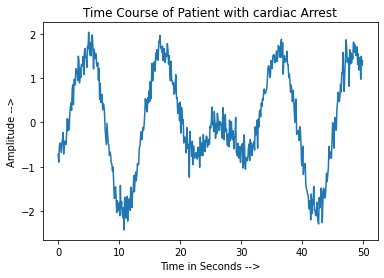


Number of data points associated with Cardic Arrest Cases :  180
Number of data points associated with Control Subjects :  220


Dataset Max age:  90
Dataset Min age:  33



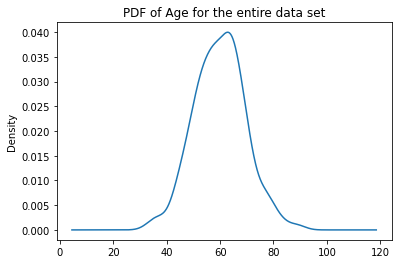

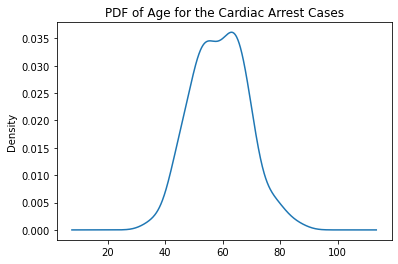

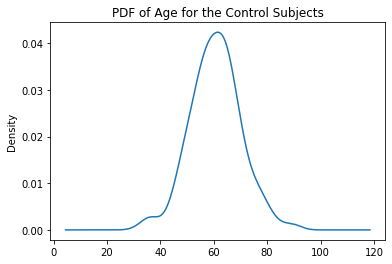

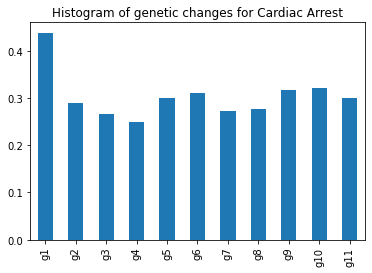

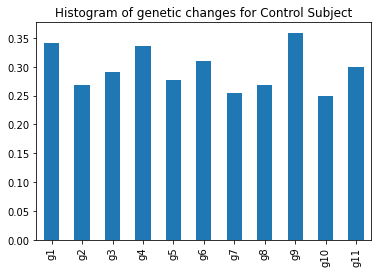

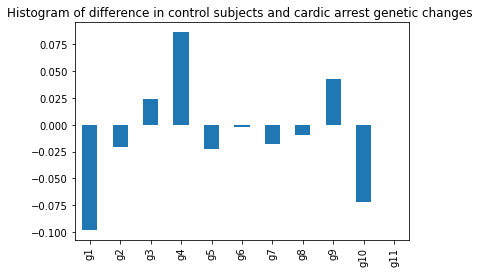

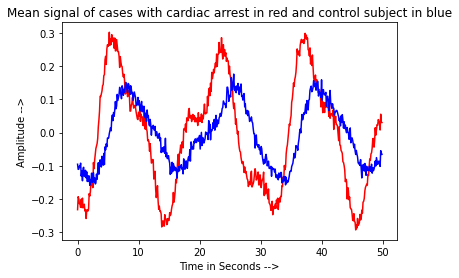

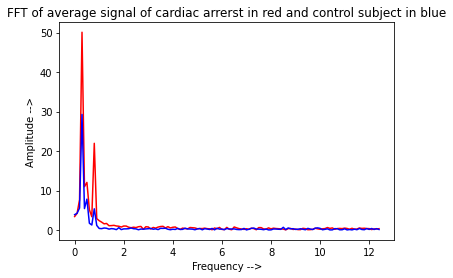

In [3]:
# Sample print of the demographic data 
print(df_data[0:20])
print('\n')

#sample plot of time course signal
y=df_curves.iloc[0].values
x=[i/10 for i in range(len(y))]
plt.plot(x,y)
if df_data['Arrest'].iloc[0]==1:
  plt.title('Time Course of Patient with cardiac Arrest')
else:
  plt.title('Time Course of Control Subject')
plt.ylabel('Amplitude -->')
plt.xlabel('Time in Seconds -->')
plt.show()

# Number of Examples per case
total_data_points=len(df_data)
num_cardiac_arrest=df_data['Arrest'].sum()
num_control_subject=total_data_points-num_cardiac_arrest
print()
print("Number of data points associated with Cardic Arrest Cases : ",num_cardiac_arrest)
print("Number of data points associated with Control Subjects : ",num_control_subject)


# Age range
print()
combined_df=pd.concat([df_data,df_curves],axis=1)
cardiac_arrest_data=combined_df.query('Arrest==1')
control_subject_data=combined_df.query('Arrest==0')
max_age=df_data['Age_y'].max()
min_age=df_data['Age_y'].min()
print()
print('Dataset Max age: ',max_age)
print('Dataset Min age: ',min_age)


#PDF of age for various cases
print()
plt.figure()
combined_df['Age_y'].plot.density()
plt.title('PDF of Age for the entire data set')
plt.show()
print()
plt.figure()
cardiac_arrest_data['Age_y'].plot.density()
plt.title('PDF of Age for the Cardiac Arrest Cases')
plt.show()
print()
plt.figure()
control_subject_data['Age_y'].plot.density()
plt.title('PDF of Age for the Control Subjects')
plt.show()

# Histogram of Genetic Mutation
print()
plt.figure()
gm_ca=cardiac_arrest_data.iloc[:,2:13].sum(axis=0)/num_cardiac_arrest
gm_ca.plot(kind='bar')
plt.title('Histogram of genetic changes for Cardiac Arrest')
plt.show()
print()
plt.figure()
gm_cs=control_subject_data.iloc[:,2:13].sum(axis=0)/num_control_subject
gm_cs.plot(kind='bar')
plt.title('Histogram of genetic changes for Control Subject')
plt.show()

print()
gm_diff=gm_cs-gm_ca
plt.figure()
gm_diff.plot(kind='bar')
plt.title('Histogram of difference in control subjects and cardic arrest genetic changes ')
plt.show()

## Time course signal Plots
avg_ca_curve=cardiac_arrest_data.iloc[:,13:].mean(axis=0)
avg_cs_curve=control_subject_data.iloc[:,13:].mean(axis=0)
print()
y1=avg_ca_curve.values
y2=avg_cs_curve.values
x=[i/10 for i in range(len(y1))]
plt.plot(x,y1,'red',x,y2,'blue')
plt.title('Mean signal of cases with cardiac arrest in red and control subject in blue')
plt.ylabel('Amplitude -->')
plt.xlabel('Time in Seconds -->')
plt.show()

print()
fft_ca_avg=abs(fft(avg_ca_curve.values))
fft_cs_avg=abs(fft(avg_cs_curve.values))
y1=fft_ca_avg[0:(int)(len(fft_ca_avg)/4)]
y2=fft_cs_avg[0:(int)(len(fft_cs_avg)/4)]
x=[i/10 for i in range(len(y1))]
plt.figure()
plt.plot(x,y1,'red',x,y2,'blue')
plt.title('FFT of average signal of cardiac arrerst in red and control subject in blue')
plt.ylabel('Amplitude -->')
plt.xlabel('Frequency -->')
plt.show()




## Model 1 with AGE , gene mutation and general statistics from Time Course

In [4]:
def sparse_to_dense(data):
  ref_vector=np.array([i for i in range(11)])
  dense_data=[]
  max_length=0
  for dat_vector in data:
    temp_dense=dat_vector*ref_vector
    if max_length<temp_dense[temp_dense!=0].shape[0]:
      max_length=temp_dense[temp_dense!=0].shape[0]
    dense_data.append(temp_dense[temp_dense!=0])
  return max_length,dense_data




## Feature Transformation and preparing data 

In [6]:
ca_data=cardiac_arrest_data.iloc[:,2:13].values
cs_data=control_subject_data.iloc[:,2:13].values
ca_labels=cardiac_arrest_data.iloc[:,0].values
cs_labels=control_subject_data.iloc[:,0].values

#normalization with max_age
ca_age=cardiac_arrest_data.iloc[:,1].values/100
cs_age=control_subject_data.iloc[:,1].values/100
#extracting statistics of time course
ca_mean=cardiac_arrest_data.iloc[:,13:].mean(axis=1).values
ca_std=cardiac_arrest_data.iloc[:,13:].std(axis=1).values
cs_mean=control_subject_data.iloc[:,13:].mean(axis=1).values
cs_std=control_subject_data.iloc[:,13:].std(axis=1).values

ca_stats=np.vstack((ca_age,ca_mean,ca_std)).T
cs_stats=np.vstack((cs_age,cs_mean,cs_std)).T

#Converting mutation data from sparse to dense
max_ca_length,dense_ca=sparse_to_dense(ca_data)
max_cs_length,dense_cs=sparse_to_dense(cs_data)

max_length=0
if max_cs_length<max_ca_length:
  max_length=max_ca_length
else:
  max_length=max_cs_length
#Converting dense data to vector of fixed length
dense_ca=pad_sequences(dense_ca, maxlen=max_length, padding='post')
dense_cs=pad_sequences(dense_cs, maxlen=max_length, padding='post')
dense_ca,ca_stats=shuffle(dense_ca,ca_stats)
dense_cs,cs_stats=shuffle(dense_cs,cs_stats)



num_train_per_class=(int)((total_data_points*.8)/2)
X_train=np.vstack((dense_ca[0:num_train_per_class],dense_cs[0:num_train_per_class]))
X_train_stats=np.vstack((ca_stats[0:num_train_per_class],cs_stats[0:num_train_per_class]))
y_train=np.hstack((ca_labels[0:num_train_per_class],cs_labels[0:num_train_per_class]))
X_test=np.vstack((dense_ca[num_train_per_class:],dense_cs[num_train_per_class:]))
X_test_stats=np.vstack((ca_stats[num_train_per_class:],cs_stats[num_train_per_class:]))
y_test=np.hstack((ca_labels[num_train_per_class:],cs_labels[num_train_per_class:]))
X_train,X_train_stats,y_train=shuffle(X_train,X_train_stats,y_train)
X_test,X_test_stats,y_test=shuffle(X_test,X_test_stats,y_test)


In [13]:
input_a=Input(shape=(max_length,))
input_b=Input(shape=(3,))
x=Embedding(64,4)(input_a)
x=Reshape((max_length*4,))(x)
x=Concatenate(axis=1)([x, input_b])
x=Dense(10, activation='relu')(x)
x=Dense(1, activation='sigmoid')(x)

embed_net=Model([input_a,input_b],x)
optimizer=Adam(0.001)
embed_net.compile(optimizer=optimizer ,loss='binary_crossentropy', metrics=['accuracy'])
embed_net.fit([X_train,X_train_stats],y_train,epochs=50,batch_size=64,verbose=1)
loss,accuracy = embed_net.evaluate([X_test,X_test_stats], y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
y_predict=embed_net.predict([X_test,X_test_stats])
y_predict=np.where(y_predict > 0.5, 1, 0)
print('Confusion Matrix')
cm=confusion_matrix(y_test, y_predict)
print(cm)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
320/320 [==============================] - 0s 331us/step - loss: 0.7036 - accuracy: 0.5000
Epoch 2/50
320/320 [==============================] - 0s 32us/step - loss: 0.7005 - accuracy: 0.5000
Epoch 3/50
320/320 [==============================] - 0s 30us/step - loss: 0.6980 - accuracy: 0.5000
Epoch 4/50
320/320 [==============================] - 0s 29us/step - loss: 0.6955 - accuracy: 0.5000
Epoch 5/50
320/320 [==============================] - 0s 43us/step - loss: 0.6936 - accuracy: 0.5000
Epoch 6/50
320/320 [==============================] - 0s 31us/step - loss: 0.6919 - accuracy: 0.5000
Epoch 7/50
320/320 [==============================] - 0s 35us/step - loss: 0.6909 - accuracy: 0.5000
Epoch 8/50
320/320 [==============================] - 0s 35us/step - loss: 0.6905 - accuracy: 0.5000
Epoch 9/50
320/320 [==============================] - 0s 50us/step - loss: 0.6897 - accuracy: 0.5031
Epoch 10/50
320/320 [==============================] - 0s 47us/step - loss: 0.6892 - accur

In [14]:
print(embed_net.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 7, 4)         256         input_13[0][0]                   
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 28)           0           embedding_7[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 3)            0                                            
____________________________________________________________________________________________

## Model 2 with 1D CNN and Time course data

In [15]:
ca_data=cardiac_arrest_data.iloc[:,13:].values
cs_data=control_subject_data.iloc[:,13:].values
ca_labels=cardiac_arrest_data.iloc[:,0].values
cs_labels=control_subject_data.iloc[:,0].values



ca_data=shuffle(ca_data)
cs_data=shuffle(cs_data)

num_train_per_class=(int)((total_data_points*.8)/2)
X_train=np.vstack((ca_data[0:num_train_per_class],cs_data[0:num_train_per_class]))
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
y_train=np.hstack((ca_labels[0:num_train_per_class],cs_labels[0:num_train_per_class]))
X_test=np.vstack((ca_data[num_train_per_class:],cs_data[num_train_per_class:]))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_test=np.hstack((ca_labels[num_train_per_class:],cs_labels[num_train_per_class:]))
X_train,y_train=shuffle(X_train,y_train)
X_test,y_test=shuffle(X_test,y_test)
X_train.shape


(320, 500, 1)

In [25]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_predict=model.predict(X_test)
y_predict=np.where(y_predict > 0.5, 1, 0)
print('Confusion Matrix')
cm=confusion_matrix(y_test, y_predict)
print(cm)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/15
320/320 [==============================] - 1s 3ms/step - loss: 0.7792 - accuracy: 0.4969
Epoch 2/15
320/320 [==============================] - 1s 2ms/step - loss: 0.6445 - accuracy: 0.6313
Epoch 3/15
320/320 [==============================] - 1s 2ms/step - loss: 0.5967 - accuracy: 0.6938
Epoch 4/15
320/320 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.7125
Epoch 5/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4871 - accuracy: 0.7781
Epoch 6/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4613 - accuracy: 0.7875
Epoch 7/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4315 - accuracy: 0.8062
Epoch 8/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4032 - accuracy: 0.8219
Epoch 9/15
320/320 [==============================] - 1s 2ms/step - loss: 0.3952 - accuracy: 0.8250
Epoch 10/15
320/320 [==============================] - 1s 2ms/step - loss: 0.3695 - accuracy: 0.8344

In [19]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 498, 64)           256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 496, 64)           12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 496, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 248, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1587300   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                